### 이미지 판별을 통한 수치 예측, 메모리에서 이미지 생성  예) 바이러스의 갯수 판별, CPU or GPU

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/virus' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (3, 2) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [2]:
# 이미지 준비가 어려움으로 파이썬에서 가상의 이미지를 생성
# 난수를 만들어 난수만큼 픽셀에 값을 표시함.
width = 16
height = 16

def generate_dataset(samples):  # 1500
    # 데이터용으로 3차원 이미지가 저장된 4차원 배열로 사용할 list
    ds_x = [] # python list
    ds_y = [] # 0 ~ 255 구간의 정수, 1차원 정수 저장
    
    cnt = 0
    for it in range(samples):  # 1500: 0 ~ 1499, 1500번 처리
        # yellow point의 갯수
        num_pt = np.random.randint(0, height * width)  # 256: 0 ~ 255
        img = generate_image(num_pt)  # yellow point가 7 이라면

        # list에 3차원 이미지 저장
        ds_x.append(img)     

        # 실제답, 0 ~ 255 구간의 정수, 레이블, class: 7 가정
        ds_y.append(num_pt)
        
    
    # ds_x를 배열로 변경, ds_y를 1500행 1열로 변환
    # np.array(ds_x): 3차원 이미지가 저장된 list를 4차원 배열 형태로 리턴
    # np.array(ds_y).reshape(samples, 1): ds_y 1차원 list를 배열로 바꾼후
    #                                1500행 1열 2차원 배열로 변경하여 리턴
    return np.array(ds_x), np.array(ds_y).reshape(samples, 1)

# 전달된 수만큼 무작위 위치에 1을 지정, 7: 7개의 1일 할당됨.
def generate_image(points): # 0 ~ 255, 7이라고 가정
    img = np.zeros((width, height))  # 16 x 16의 0으로 채워진 행렬
    # 7이하면 7행 2열의 난수 발생, 행과 열로 사용할 난수 생성
    # yellow point의 위치는 행과열로 구성되어 있음으로 2차원의 형태여야함.
    pts = np.random.random((points, 2)) 
    
    # pts는 2차원 배열이나 for문 때문에 하나의 행씩 추출됨. 
    # [0.26333527, 0.20043297]
    for ipt in pts: 
        # int(0.26333527 * 16), int(0.20043297 * 16)] = 1
        img[int(ipt[0] * width), int(ipt[1] * height)] = 1 # 점, point
    
    # 2차원 배열을 3차원으로 변형하여 리턴
    return img.reshape(width, height, 1) # 16 x 16의 1: 흑백 이미지 생성

In [3]:
x_train, y_train = generate_dataset(3000) # 훈련용 3000 개
x_test, y_test = generate_dataset(300)    # 테스트용 300 개
print(x_train.shape) # (3000, 16, 16, 1) 16 x 16 픽셀 흑백 이미지 3000 개 생성
print(x_test.shape) # (3000, 16, 16, 1) 16 x 16 픽셀 흑백 이미지 3000 개 생성
print(type(x_train[0, 0, 0, 0]))

(3000, 16, 16, 1)
(300, 16, 16, 1)
<class 'numpy.float64'>


In [4]:
# 데이터 준비
x_train, y_train = generate_dataset(3000) # 훈련용
x_test, y_test = generate_dataset(300)    # 테스트용 
width=16
height=16

# 네트워크 구성
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
# input_shape = (width, height, 1): 흑백 입력 1
model.add(Conv2D(128, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width,  1), activation='relu'))
model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(1)) # 활성화 함수 생략시 수치 예측(회귀 산출)
model.compile(optimizer=Adam(lr=0.00001), loss='mse')

model.summary()

# patience=2: 오차가 2번 증가하면 종료
es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

start = time.time()
hist = model.fit(x_train, y_train, validation_split=0.2, 
                 shuffle=True, epochs=1000, 
                 batch_size=1, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# i5 2320: 53 초, 659.24 초
# gtx 1060: 28 초

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 128)       1280      
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1)                 32769     
                                                                 
Total params: 34,049
Trainable params: 34,049
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
2400/2400 [==============================] - 4s 2ms/step - loss: 16325.4834 - val_loss: 7195.9673
Epoch 2/1000
2400/2400 [==============================] - 4s 2ms/step - loss: 2473.6377 - val_loss: 738.8994
Epoch 3/1000
2400/2400 [==============================] - 4s 1ms/step - loss: 660.5928 - val_los

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


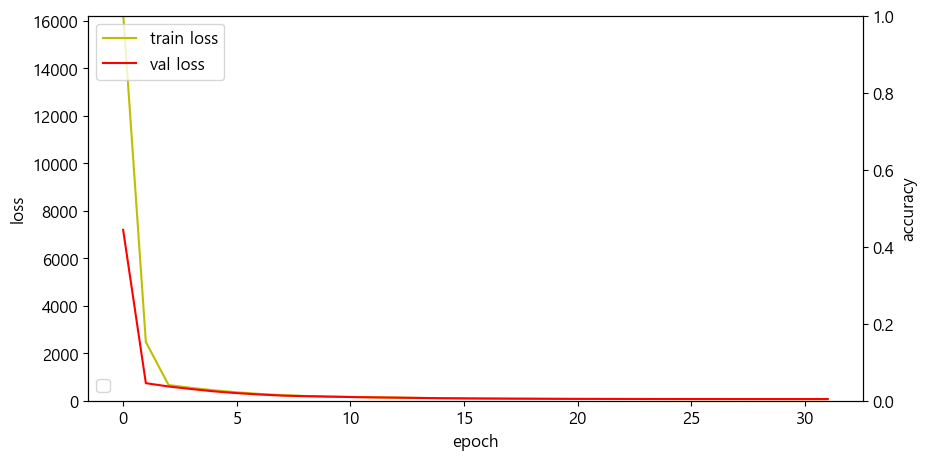

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 16214.0283]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
# acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
# acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()


In [6]:
yp = model.predict(x_test, batch_size=20)
print(yp[0:10])

[[172.02058 ]
 [ 12.414755]
 [129.56007 ]
 [ 34.278122]
 [221.33392 ]
 [ 62.216003]
 [ 56.805176]
 [ 83.16488 ]
 [173.51323 ]
 [218.20862 ]]


(16, 16, 1)


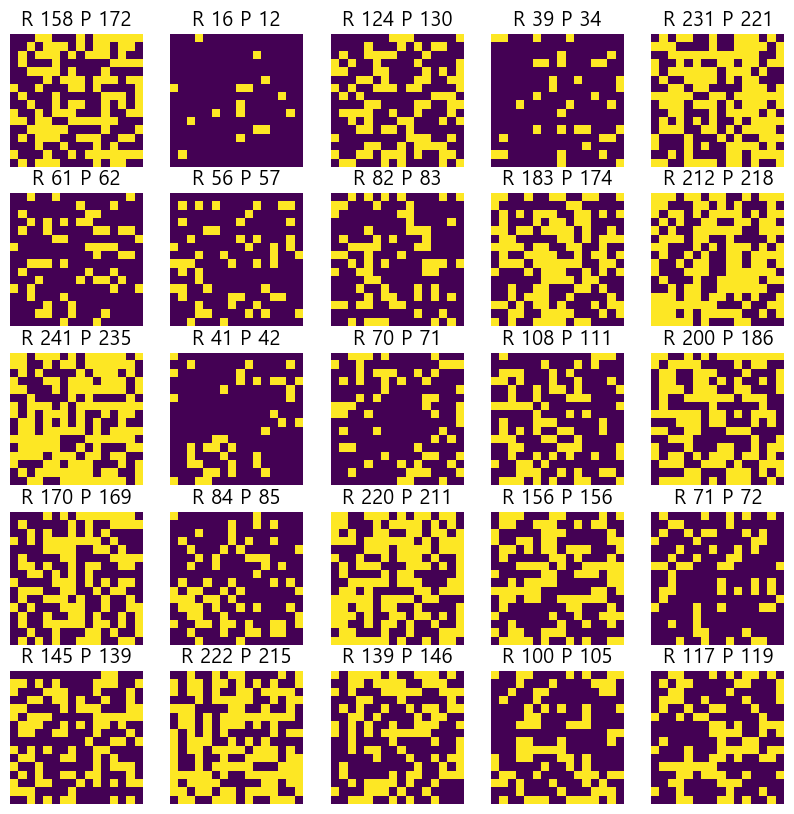

In [7]:
print(x_test[0].shape)
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i//plt_row, i%plt_col]  # //: 정수형 나누기
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R %d P %.0f' % (y_test[i][0], yp[i][0]))  # R: 실제값, P: 예측한 값

plt.show()